In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 19.8 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

In [4]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in tqdm(os.listdir(path)):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image

                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# get relativ Path of the data
current_dir = os.getcwd()  # current directory
norm_data_dir = os.path.join(current_dir, "../..", "normData")

#load the data
train_data = get_training_data('/content/drive/MyDrive/normData/train')
val_data = get_training_data('/content/drive/MyDrive/normData/val')
test_data = get_training_data('/content/drive/MyDrive/normData/test')

100%|██████████| 390/390 [00:07<00:00, 54.08it/s] 


In [5]:
# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []

    for img, label in tqdm(data):
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)

    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)


# Check the shape and an example of the normalized and shuffled data
print('\n')
print(f"Shape of normalized and shuffled test images: {test_images.shape}")
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

100%|██████████| 624/624 [00:00<00:00, 14003.23it/s]



Shape of normalized and shuffled test images: (624, 224, 224)
Shape of normalized and shuffled train images: (7550, 224, 224)
Shape of normalized and shuffled validation images: (216, 224, 224)


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the images and labels to PyTorch tensors

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in train_images]).unsqueeze(1)
val_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in val_images]).unsqueeze(1)
test_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in test_images]).unsqueeze(1)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2, 3)  # (N, 1, 244, 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2, 3)      # (N, 1, 244, 244)
test_images_tensor = test_images_tensor.permute(0, 1, 2, 3)    # (N, 1, 244, 244)
print(train_images_tensor.shape, val_images_tensor.shape, test_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
print('Done!')



torch.Size([7550, 1, 224, 224]) torch.Size([216, 1, 224, 224]) torch.Size([624, 1, 224, 224])
Done!


In [16]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2, softmax=True):
      super(ResNet, self).__init__()
      self.resnet = torchvision.models.resnet18(pretrained=True)
      num_ftrs = self.resnet.fc.out_features
      self.fc = nn.Linear(num_ftrs, num_classes)
      self.bn = nn.BatchNorm1d(num_ftrs)
      self.relu = nn.ReLU()
      self.softmax = torch.nn.Softmax(dim=1) if softmax else None
      self.change_conv1()

    def forward(self, x):
      x = self.resnet(x)
      x = self.bn(x)
      x = self.relu(x)
      x = self.fc(x)
      if self.softmax:
        x = self.softmax(x)
      return x

    def change_conv1(self):
      original_conv1 = self.resnet.conv1

      #Create a new convolutional layer with 1 input channel instead of 3
      new_conv1 = nn.Conv2d(
        in_channels=1,  # Grayscale has 1 channel
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
)

      # Initialize the new conv layer's weights by averaging the RGB weights
      with torch.no_grad():
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))

        #Replace the original conv1 with the new one
        self.resnet.conv1 = new_conv1


model = ResNet(num_classes=2, softmax=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)




cuda:0


### **Training**

Start training of: ResNet18


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.00it/s]


Epoch 1/100 - Validation F1 Score: 0.9859 - Validation Recall Score: 1.0000 - Validation Precision Score: 0.9722
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.83it/s]


Epoch 2/100 - Validation F1 Score: 0.9813 - Validation Recall Score: 0.9906 - Validation Precision Score: 0.9722


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 65.76it/s]


Epoch 3/100 - Validation F1 Score: 0.9714 - Validation Recall Score: 1.0000 - Validation Precision Score: 0.9444


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.14it/s]


Epoch 4/100 - Validation F1 Score: 0.9730 - Validation Recall Score: 0.9474 - Validation Precision Score: 1.0000


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.97it/s]


Epoch 5/100 - Validation F1 Score: 0.9862 - Validation Recall Score: 0.9817 - Validation Precision Score: 0.9907
Exceeded


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 78.90it/s]


Epoch 6/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907
Exceeded


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.98it/s]


Epoch 7/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.58it/s]


Epoch 8/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 83.66it/s]


Epoch 9/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.60it/s]


Epoch 10/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.51it/s]


Epoch 11/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.06it/s]


Epoch 12/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.30it/s]


Epoch 13/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 83.79it/s]


Epoch 14/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.69it/s]


Epoch 15/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.77it/s]


Epoch 16/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.34it/s]


Epoch 17/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.92it/s]


Epoch 18/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 82.23it/s]


Epoch 19/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.52it/s]


Epoch 20/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.13it/s]


Epoch 21/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 83.61it/s]


Epoch 22/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.55it/s]


Epoch 23/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.48it/s]


Epoch 24/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.64it/s]


Epoch 25/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.19it/s]


Epoch 26/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 82.67it/s]


Epoch 27/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.37it/s]


Epoch 28/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.78it/s]


Epoch 29/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.01it/s]


Epoch 30/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.49it/s]


Epoch 31/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.21it/s]


Epoch 32/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.73it/s]


Epoch 33/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.77it/s]


Epoch 34/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.50it/s]


Epoch 35/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.42it/s]


Epoch 36/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.50it/s]


Epoch 37/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.55it/s]


Epoch 38/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.33it/s]


Epoch 39/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 78.38it/s]


Epoch 40/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.01it/s]


Epoch 41/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.45it/s]


Epoch 42/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 82.04it/s]


Epoch 43/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.63it/s]


Epoch 44/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.56it/s]


Epoch 45/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.72it/s]


Epoch 46/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.64it/s]


Epoch 47/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 82.08it/s]


Epoch 48/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.90it/s]


Epoch 49/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 83.69it/s]


Epoch 50/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 42.11it/s]


Epoch 51/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.23it/s]


Epoch 52/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.09it/s]


Epoch 53/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.33it/s]


Epoch 54/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.60it/s]


Epoch 55/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.08it/s]


Epoch 56/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.37it/s]


Epoch 57/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.32it/s]


Epoch 58/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 79.14it/s]


Epoch 59/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.79it/s]


Epoch 60/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.87it/s]


Epoch 61/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.99it/s]


Epoch 62/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.57it/s]


Epoch 63/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 76.09it/s]


Epoch 64/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.42it/s]


Epoch 65/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.63it/s]


Epoch 66/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.84it/s]


Epoch 67/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.40it/s]


Epoch 68/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.64it/s]


Epoch 69/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.55it/s]


Epoch 70/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.40it/s]


Epoch 71/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 78.72it/s]


Epoch 72/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.72it/s]


Epoch 73/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.11it/s]


Epoch 74/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 81.45it/s]


Epoch 75/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 89.33it/s]


Epoch 76/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.49it/s]


Epoch 77/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 81.21it/s]


Epoch 78/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.32it/s]


Epoch 79/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.87it/s]


Epoch 80/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.43it/s]


Epoch 81/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.35it/s]


Epoch 82/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 81.58it/s]


Epoch 83/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 87.47it/s]


Epoch 84/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.98it/s]


Epoch 85/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 80.70it/s]


Epoch 86/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.56it/s]


Epoch 87/100 - Validation F1 Score: 0.9861 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9815


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.33it/s]


Epoch 88/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.49it/s]


Epoch 89/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.29it/s]


Epoch 90/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 83.09it/s]


Epoch 91/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.80it/s]


Epoch 92/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.31it/s]


Epoch 93/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 86.56it/s]


Epoch 94/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.55it/s]


Epoch 95/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.35it/s]


Epoch 96/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 84.38it/s]


Epoch 97/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 85.27it/s]


Epoch 98/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 76.47it/s]


Epoch 99/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 88.85it/s]


Epoch 100/100 - Validation F1 Score: 0.9907 - Validation Recall Score: 0.9907 - Validation Precision Score: 0.9907
Best F1: 0.9907, Precision: 0.9907, Recall: 0.9907






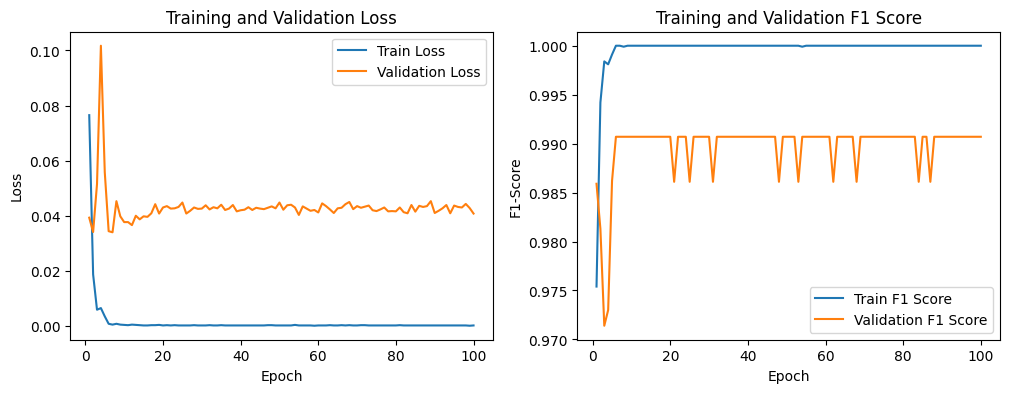

In [17]:
from torchmetrics import Precision, Recall, F1Score
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt

# Define params
learning_rate = 0.0001
batch_size = 32
weight_decay = 1e-6
criterion = torch.nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # AdamW with L2 regularization


def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    patience_counter = 0
    best_validation_f1 = 0
    best_validation_recall = 0
    best_validation_precision = 0
    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []
    val_recalls = []
    val_precisions = []
    recall_score_metric = Recall(task='binary')
    precision_score_metric = Precision(task='binary')
    f1_score_metric = F1Score(task='binary')
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    for epoch in range(num_epochs):
        model.train()
        p_bar = tqdm(train_loader)
        running_loss = 0
        all_preds = []
        all_labels = []
        for i, (images, labels) in enumerate(p_bar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())
            p_bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {(running_loss / (i + 1)):.4f}")

        train_losses.append(round(running_loss / len(train_loader), 4))
        all_preds = torch.tensor(all_preds, dtype=torch.float32)
        all_labels = torch.tensor(all_labels, dtype=torch.long)
        train_f1s.append(round(f1_score_metric(all_labels, all_preds).item(), 4))

        if (epoch + 1) % 1 == 0:
            model.eval()
            p_bar = tqdm(val_loader)
            all_preds = []
            all_labels = []
            with torch.no_grad():
                running_loss = 0
                for i, (images, labels) in enumerate(p_bar):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    outputs = F.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu())
                    all_labels.extend(labels.cpu())
                    p_bar.set_description(f'Epoch {epoch+1}/{num_epochs} - Validation Batch: {i}')

                all_preds = torch.tensor(all_preds, dtype=torch.float32)
                all_labels = torch.tensor(all_labels, dtype=torch.long)
                precision = round(precision_score_metric(all_labels, all_preds).item(), 4)
                recall = round(recall_score_metric(all_labels, all_preds).item(), 4)
                f1 = round(2 * (precision * recall)/(precision + recall + 1e-10), 4)

                val_losses.append(round(running_loss / len(val_loader), 4))
                val_f1s.append(f1)
                val_recalls.append(recall )
                val_precisions.append(precision)

                print(f"Epoch {epoch+1}/{num_epochs} - Validation F1 Score: {f1:.4f} - Validation Recall Score: {recall:.4f} - Validation Precision Score: {precision:.4f}")
                if f1 > best_validation_f1:
                    best_validation_f1 = f1
                    best_validation_precision = precision
                    best_validation_recall = recall
                    patience_counter = 0
                    print('Exceeded')
                    torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_results', 'best_model_resnet.pth'))

                else:
                    patience_counter += 1
            scheduler.step()
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_validation_f1, best_validation_precision, best_validation_recall


model_name = 'ResNet18'
print(f'Start training of: {model_name}')
train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_val_f1, best_val_precision, best_val_recall = train_model(model, _, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)

# Start training
print(f'Best F1: {best_val_f1}, Precision: {best_val_precision}, Recall: {best_val_recall}')
#print('Val F1s', val_f1s)
#print('Val Recalls: ', val_recalls)
#print('Val Precisons: ', val_precisions)

# Plot training and validation loss

out_dict = {
    'train_losses': train_losses,
    'train_f1s': train_f1s,
    'val_losses': val_losses,
    'val_f1s': val_f1s,
    'val_recalls': val_recalls,
    'val_precisions': val_precisions,
    'best_val_f1': best_val_f1,
    'best_val_precision': best_val_precision,
    'best_val_recall': best_val_recall
}

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_f1s) + 1), train_f1s, label='Train F1 Score')
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1 Score')
plt.legend()
#plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/model_results/{model_name}_F1.png')
print('\n\n\n')

with open(f'/content/drive/MyDrive/model_results/{model_name}results.json', 'w') as fp:
  json.dump({'ResNet18': out_dict}, fp, indent=2)

### **Testing**

In [18]:
state_dict = torch.load('/content/drive/MyDrive/model_results/best_model_resnet.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:

recall_score_metric = Recall(task='binary')
precision_score_metric = Precision(task='binary')

all_preds = []
all_labels = []
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  _, preds = torch.max(outputs, 1)
  all_preds.extend(preds.cpu())
  all_labels.extend(labels)

all_preds = torch.tensor(all_preds, dtype=torch.float32)
all_labels = torch.tensor(all_labels, dtype=torch.long)
precision = round(precision_score_metric(all_labels, all_preds).item(), 4)
recall = round(recall_score_metric(all_labels, all_preds).item(), 4)
f1 = round(2 * (precision * recall)/(precision + recall + 1e-10), 4)

print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')






Precision: 0.9974, Recall: 0.7843, F1: 0.8781
